In [21]:
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
data_path = '../data/'
img_file = glob.glob(os.path.join(data_path, 'original_img/*'))

In [23]:
name = []
name.append('dummy.jpg')
name.append('joker.jpg')
for suite in ['s', 'h', 'd', 'c']:
    for num in range(1,14):
        name.append(suite+str(num)+'.jpg')
name.append('back.jpg')

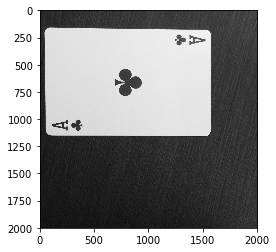

In [90]:
img = cv2.imread(img_file[1])
img = img[0:2000, :2000]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

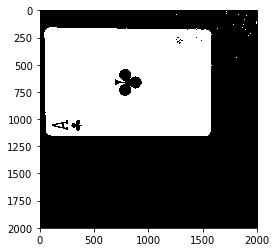

In [91]:
ret, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_TOZERO_INV)
ret, thresh = cv2.threshold(1-thresh, 80, 255, cv2.THRESH_TOZERO_INV)
plt.imshow(thresh, cmap='gray')

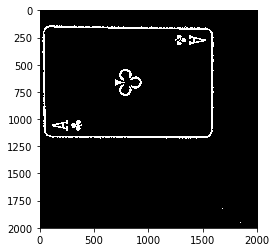

In [92]:
thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 99, 20)
plt.imshow(thresh2, cmap='gray')

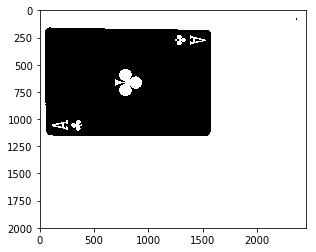

In [72]:
thresh3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
plt.imshow(thresh3, cmap='gray')

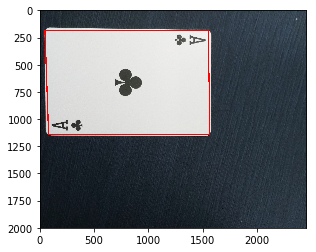

In [73]:
contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
th_area = img.shape[0] * img.shape[1] / 100
contours_large = list(filter(lambda c:cv2.contourArea(c) > th_area, contours))

approxes = []
for (i,cnt) in enumerate(contours_large):
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.1*arclen, True)
    if len(approx) < 4:
        continue
    approxes.append(approx)
    
test = np.copy(img)
cv2.polylines(test, approxes,True,(255,0,0),10)
plt.imshow(test)

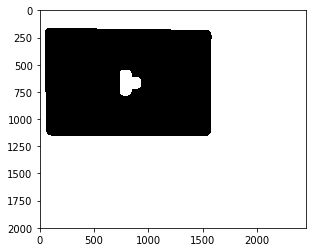

In [96]:
erase = np.copy(thresh3)
close_kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(erase, cv2.MORPH_CLOSE, close_kernel, iterations=10)

open_kernel = np.ones((50,50),np.uint8)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, open_kernel, iterations=1)

erode_kernel = np.ones((3,3),np.uint8)
dilation = 255 - cv2.dilate(opening, erode_kernel, iterations = 2)
plt.imshow(opening, cmap='gray')

In [31]:
def get_maxmin(img):
    # img: crop region must be 0 and else 255
    non_zero = np.argwhere(img==255)
    x_min = np.min(non_zero[:,0])
    y_min = np.min(non_zero[:,1])
    x_max = np.max(non_zero[:,0])
    y_max = np.max(non_zero[:,1])
    return x_min, y_min, x_max, y_max

In [66]:
from scipy.ndimage.interpolation import rotate
def calc_area(img):
    x_min, y_min, x_max, y_max = get_maxmin(img)
    return (x_max-x_min) * (y_max-y_min)

def rotate_min(img):
    # rotate img so that crop region is minimum
    area = calc_area(img)
    angle = 0.0
    num_try = 0
    while True:
        angle += 0.2
        img = rotate(img, angle)
        new_area = calc_area(img)
        if new_area > area:
            num_try += 1
            if num_try == 3:
                break
        else:
            num_try = 0
            area = new_area
    if angle == 0.2:
        num_try = 0
        angle = 0.0
        while True:
            angle -= 0.2
            img = rotate(img, angle)
            new_area = calc_area(img)
            if new_area > area:
                if num_try == 3:
                    break
            else:
                num_try = 0
                area = new_area
    if angle == -0.2:
        angle = 0.0
    return angle

In [67]:
angle = rotate_min(dilation)

In [68]:
angle

1.4

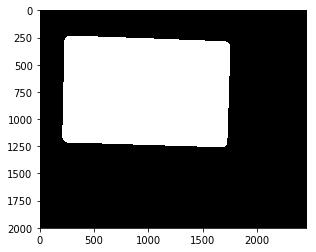

In [60]:
plt.imshow(dilation, cmap='gray')

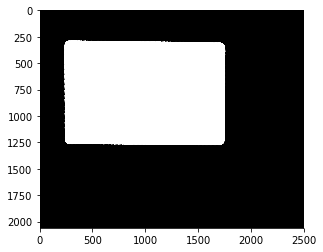

In [62]:
plt.imshow(rotate(dilation, 1.4), cmap='gray')

In [63]:
new_img = np.c_[img, np.expand_dims(dilation, axis=-1)]
new_img = rotate(new_img, angle)

In [64]:
x_min, y_min, x_max, y_max = get_maxmin(rotate(dilation, angle))
# x_min, y_min, x_max, y_max = get_maxmin(dilation)
new_img = new_img[x_min-1:x_max+1, y_min-1:y_max+1]

In [65]:
file_name = img_file[0].split('/')[-1]
save_dir = os.path.join(data_path, 'cards_data', file_name)
cv2.imwrite('test4.png', new_img)

True